# 1. What is PCA?
* The PCA Algorithm works by computing principal components where it retains datasets in the **direction of maximum variance** in the original datasets
* PCA is a procedure that uses an orthogonal transformation to convert a set of observations possibly correlated variables into a set of values of linearly uncorrelated variables.

## Import required libraries & data

In [555]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [468]:
np.random.seed(42)

In [469]:
data = pd.read_csv("activity_sleep_label.csv")
data

,EMAIL,DIAG_NM,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,...,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_total
0,nia+003@rowan.kr,MCI,1.262897,202.571429,2208.333333,3659.730159,0.793651,615.142857,0.809524,146.428571,...,74.809524,75.492063,57.634921,65.253968,78.650794,54.904762,69.730159,0.022222,0.022222,23543.809524
1,nia+005@rowan.kr,CN,1.370299,217.477876,1773.504425,5084.876106,0.256637,574.619469,0.539823,281.300885,...,86.849558,89.345133,83.601770,97.663717,83.973451,74.433628,81.097345,0.057434,0.057434,28060.088496
2,nia+010@rowan.kr,MCI,1.390625,259.672414,2365.137931,3877.741379,0.637931,632.482759,0.362069,328.827586,...,97.931034,61.517241,63.758621,58.034483,76.965517,64.672414,58.344828,-0.045862,-0.045862,20247.413793
3,nia+013@rowan.kr,MCI,1.478484,493.147541,2577.590164,8769.811475,0.836066,481.016393,0.745902,314.918033,...,90.139344,97.606557,72.549180,88.073770,81.721311,36.295082,69.049180,0.008033,0.008033,23163.196721
4,nia+014@rowan.kr,MCI,1.442555,401.382353,2503.882353,7250.514706,0.382353,534.470588,0.176471,343.852941,...,94.764706,76.867647,55.500000,66.970588,82.500000,38.779412,63.573529,-0.129706,-0.129706,21879.264706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,nia+456@rowan.kr,CN,1.542480,573.781250,2676.125000,10846.750000,5.421875,610.515625,0.609375,283.140625,...,88.718750,85.031250,57.468750,42.156250,83.828125,31.234375,51.750000,-0.125469,-0.125469,18961.875000
170,nia+458@rowan.kr,CN,1.257353,200.549020,2206.941176,3377.098039,0.588235,507.117647,0.392157,206.823529,...,90.686275,88.882353,72.745098,67.705882,75.529412,82.607843,85.274510,-0.040000,-0.040000,28078.823529
171,nia+462@rowan.kr,MCI,1.595274,654.780488,2748.975610,12247.487805,3.121951,473.658537,0.560976,309.951220,...,90.073171,99.634146,71.121951,63.146341,85.317073,28.951220,68.634146,-0.037317,-0.037317,23045.121951
172,nia+475@rowan.kr,CN,1.397418,311.869565,2410.043478,5543.195652,0.108696,675.282609,1.130435,278.891304,...,57.130435,94.456522,68.130435,80.413043,85.913043,27.586957,54.695652,-0.159348,-0.159348,19752.391304


# 2. What is the step-by-step procedure of PCA?

## 2.1. Perform data pre-processing
(e.g. scaling on D-dimensional data)
* It is critical to perform normalization prior to implementing the PCA algorithm

In [556]:
# Exclude categorical data (dtype = string)
to_be_normed = [col for col in data.columns if data[col].dtypes != 'object']
# 1. Standardize the numerical data
standardized_data = normalize(data[to_be_normed])
standardized_data

array([[ 2.62348609e-05,  4.20812939e-03,  4.58749414e-02, ...,
         4.61634630e-07,  4.61634630e-07,  4.89088701e-01],
       [ 2.76175314e-05,  4.38313354e-03,  3.57438967e-02, ...,
         1.15753964e-06,  1.15753964e-06,  5.65533917e-01],
       [ 3.38795672e-05,  6.32635613e-03,  5.76214647e-02, ...,
        -1.11733001e-06, -1.11733001e-06,  4.93284398e-01],
       ...,
       [ 2.72332176e-05,  1.11778761e-02,  4.69282598e-02, ...,
        -6.37046505e-07, -6.37046505e-07,  3.93407444e-01],
       [ 3.47600852e-05,  7.75759934e-03,  5.99486252e-02, ...,
        -3.96369742e-06, -3.96369742e-06,  4.91330847e-01],
       [ 3.12045839e-05,  6.78226659e-03,  5.43510089e-02, ...,
        -2.02685478e-07, -2.02685478e-07,  5.10305589e-01]])

## 2.2. Compute a covariance matrix
* This is needed to understand how features are correlated with each other
* The covariance matrix is N X N symmetric matrix where N is the # of dimensions

In [557]:
# 2. Calculate the covariance matrix
cov_matrix = np.cov(standardized_data, rowvar=False)
cov_matrix

array([[ 2.52316749e-11,  1.51178441e-08,  4.19631873e-08, ...,
        -2.24954732e-13, -2.24954732e-13, -1.92505209e-08],
       [ 1.51178441e-08,  1.82630954e-05,  2.72415805e-05, ...,
         1.71732147e-10,  1.71732147e-10, -6.02912971e-05],
       [ 4.19631873e-08,  2.72415805e-05,  7.60364908e-05, ...,
        -9.75175533e-10, -9.75175533e-10, -4.06680888e-05],
       ...,
       [-2.24954732e-13,  1.71732147e-10, -9.75175533e-10, ...,
         2.81173699e-12,  2.81173699e-12, -1.06003591e-09],
       [-2.24954732e-13,  1.71732147e-10, -9.75175533e-10, ...,
         2.81173699e-12,  2.81173699e-12, -1.06003591e-09],
       [-1.92505209e-08, -6.02912971e-05, -4.06680888e-05, ...,
        -1.06003591e-09, -1.06003591e-09,  1.52055688e-03]])

In [472]:
# The covariance matrix is N X N symmetric matrix where N is the # of dimensions
print(f"Dimension of the data:{standardized_data.shape[1]}")
print(f"Shape of the covariance matrix:{cov_matrix.shape}")

Dimension of the data:51
Shape of the covariance matrix:(51, 51)


## 2.3. Calculate the eigenvalues and eigenvectors of the covariance matrix
* This is needed to determine the **principal components** of the dataset

In [560]:
# 3. Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
print(f"Dimension of the data: {standardized_data.shape[1]}")
print(f"The number of the eigenvectors: {len(eigenvectors)}")
print(f"Shape of the eigenvectors: {eigenvectors.shape}")

Dimension of the data: 51
The number of the eigenvectors: 51
Shape of the eigenvectors: (51, 51)


In [561]:
eigenvalues

array([-6.08926987e-20,  1.31342704e-35,  3.76784777e-19,  2.25300143e-18,
        2.16174160e-15,  1.71708513e-14,  3.46630677e-13,  2.00993493e-12,
        3.63971342e-12,  4.66073277e-12,  3.66390545e-11,  5.60900862e-11,
        1.81666369e-10,  3.28709097e-10,  3.97694441e-10,  4.40026746e-10,
        6.11022761e-10,  8.89299105e-10,  1.12182402e-09,  1.62623198e-09,
        2.79558684e-09,  3.35123416e-09,  4.30040023e-09,  5.48214033e-09,
        6.74771486e-09,  9.01348912e-09,  1.70794916e-08,  2.42348503e-08,
        2.90564776e-08,  3.38848835e-08,  3.67915141e-08,  4.90496614e-08,
        5.75869254e-08,  6.42588183e-08,  1.74274282e-07,  2.79278229e-07,
        3.71030422e-07,  4.53781788e-07,  1.09609853e-06,  1.76850335e-06,
        5.22922144e-06,  1.38202860e-05,  3.22513177e-05,  3.66087314e-05,
        1.26552825e-04,  3.47942130e-04,  9.44952416e-04,  2.11577194e-03,
        2.68908660e-03,  1.02123524e-02,  1.84998578e-02])

In [562]:
eigenvectors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.15349852e-06, -2.23504043e-06,  2.81099994e-05],
       [ 3.90995312e-11, -5.08166237e-19,  6.86860231e-10, ...,
         2.25099996e-03,  1.29022342e-02,  2.93778006e-02],
       [-6.54706674e-12,  7.81011428e-20,  7.34610814e-11, ...,
        -1.28359081e-02, -1.39106310e-03,  4.77521749e-02],
       ...,
       [ 1.18650260e-08, -7.07106781e-01,  5.31134836e-08, ...,
        -1.19241563e-06,  2.12543394e-07,  7.20894446e-07],
       [ 1.18650252e-08,  7.07106781e-01,  5.31134837e-08, ...,
        -1.19241563e-06,  2.12543394e-07,  7.20894446e-07],
       [ 2.84131817e-01,  1.70262720e-16,  4.29233886e-01, ...,
        -3.22116806e-01, -2.82242153e-01, -4.14991266e-02]])

## 2.4. Sort the eigenvalue in descending order and find the corresponding eigenvector.

In [474]:
# 4. Sort eigenvectors in descending order of eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalue = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:,sorted_indices]

In [475]:
sorted_eigenvalue

array([ 1.84998578e-02,  1.02123524e-02,  2.68908660e-03,  2.11577194e-03,
        9.44952416e-04,  3.47942130e-04,  1.26552825e-04,  3.66087314e-05,
        3.22513177e-05,  1.38202860e-05,  5.22922144e-06,  1.76850335e-06,
        1.09609853e-06,  4.53781788e-07,  3.71030422e-07,  2.79278229e-07,
        1.74274282e-07,  6.42588183e-08,  5.75869254e-08,  4.90496614e-08,
        3.67915141e-08,  3.38848835e-08,  2.90564776e-08,  2.42348503e-08,
        1.70794916e-08,  9.01348912e-09,  6.74771486e-09,  5.48214033e-09,
        4.30040023e-09,  3.35123416e-09,  2.79558684e-09,  1.62623198e-09,
        1.12182402e-09,  8.89299105e-10,  6.11022761e-10,  4.40026746e-10,
        3.97694441e-10,  3.28709097e-10,  1.81666369e-10,  5.60900862e-11,
        3.66390545e-11,  4.66073277e-12,  3.63971342e-12,  2.00993493e-12,
        3.46630677e-13,  1.71708513e-14,  2.16174160e-15,  2.25300143e-18,
        3.76784777e-19,  1.31342704e-35, -6.08926987e-20])

In [476]:
sorted_eigenvectors = eigenvectors[:,sorted_indices]
sorted_eigenvectors

array([[ 2.81099994e-05, -2.23504043e-06, -8.15349852e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.93778006e-02,  1.29022342e-02,  2.25099996e-03, ...,
         6.86860231e-10, -5.08166237e-19,  3.90995312e-11],
       [ 4.77521749e-02, -1.39106310e-03, -1.28359081e-02, ...,
         7.34610814e-11,  7.81011428e-20, -6.54706674e-12],
       ...,
       [ 7.20894446e-07,  2.12543394e-07, -1.19241563e-06, ...,
         5.31134836e-08, -7.07106781e-01,  1.18650260e-08],
       [ 7.20894446e-07,  2.12543394e-07, -1.19241563e-06, ...,
         5.31134837e-08,  7.07106781e-01,  1.18650252e-08],
       [-4.14991266e-02, -2.82242153e-01, -3.22116806e-01, ...,
         4.29233886e-01,  1.70262720e-16,  2.84131817e-01]])

## 2.5. Select the largest K cases (**K <= D**) and create a projection matrix (i.e. w) using the cases
* K refers to the number of principal components
* How to create a projection matrix?
  * If K=2, select two corresponding eigenvectors identified by the sorted eigenvalues
* How to determine the number of principal components?
  * Scree plot: a line plot of the eigenvalues of the eigenvalues of principal components

In [477]:
# 5. Select the largest 'num_components' eigenvectors
num_components = 2
principal_components = eigenvectors[:, 0:num_components]

In [478]:
principal_components

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 3.90995312e-11, -5.08166237e-19],
       [-6.54706674e-12,  7.81011428e-20],
       [-2.06131784e-11, -1.37970272e-20],
       [ 1.22324462e-01,  8.83007983e-17],
       [ 3.97575826e-11,  1.55963974e-19],
       [-1.00507190e-07,  1.11370552e-17],
       [ 1.22324460e-01,  8.22092347e-17],
       [ 1.22324461e-01,  8.25968625e-17],
       [ 2.43088721e-10,  1.52388525e-19],
       [-1.48469072e-09,  1.14534075e-18],
       [ 6.33712186e-10,  1.44569716e-18],
       [ 2.46290114e-10,  1.21458127e-18],
       [-3.42811425e-10,  1.48437985e-19],
       [-3.46767446e-10,  2.72342240e-19],
       [-6.48045195e-08,  1.59667710e-17],
       [ 1.61685788e-08, -3.57885472e-18],
       [-1.24547494e-09,  3.29662696e-19],
       [ 1.67942580e-08, -3.43769438e-18],
       [ 1.23942679e-08, -3.02012865e-18],
       [ 6.42007725e-09, -1.50415458e-18],
       [ 9.59022131e-09, -3.15811705e-18],
       [ 5.41362636e-12, -8.94807518e-21],
       [-1.

## 2.6. Transform data into a lower-dimensional space using the projection matrix
* For two principal components, we have:
  * Transforming by **dot product** (normalized data, projection matrix)
    * The dot product of the normalized data matrix and the projection matrix effectively projects the original data onto the subspace defined by the principal components.

In [479]:
# 6. Project the data onto the principal components
transformed_data = np.dot(principal_components.transpose(), standardized_data.transpose()).transpose()

In [480]:
transformed_data.shape

(174, 2)

# 3. Let's Compare classification w/w.o PCA (Preparation & functions)

## 3.0. Define a PCA function before the application

In [500]:
def pca(data, num_component=2, threshold = 0.01, scree = True):
    # Exclude categorical data (dtype = string)
    # to_be_normed = [col for col in X.columns if X[col].dtypes != 'object']
    # 1. Standardize the numerical data
    standardized_data = normalize(data)

    # 2. Calculate the covariance matrix
    cov_matrix = np.cov(standardized_data, rowvar=False)

    # 3. Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # 4. Sort eigenvectors in descending order of eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalue = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:,sorted_indices]

    # 5. Select the largest 'num_components' eigenvectors
    principal_components = sorted_eigenvectors[:, 0:num_component]

    # 6. Project the data onto the principal components
    transformed_data = np.dot(principal_components.transpose(), standardized_data.transpose()).transpose()

    # 7. Calculate the explained variance ratio
    explained_variance_ratio = [(i/sum(eigenvalues)) for i in sorted_eigenvalue]

    if scree == True:
        scree_plot(explained_variance_ratio, num_component, threshold)
    
    return transformed_data

## 3.1. How would you determine the number of principal components?
### Scree Plot
* A scree plot is a line of the eigenvalues of principal components

In [485]:
def scree_plot(explained_variance_ratio, num_component, threshold):
    num_components = len(explained_variance_ratio)

    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot()

    cumulated = np.cumsum(explained_variance_ratio)
    ax.bar(range(1, num_components +1), explained_variance_ratio, color = '#99ccff')
    ax.plot(range(1, num_components+1), cumulated, color = 'black')
    
    max_val = 0
    
    for value in cumulated:
        if (value - max_val) >= threshold:
            max_val = value
    
    ax.vlines(num_component, 0, max(cumulated), color = "blue", linestyles="--",label="your PC #")
    ax.vlines(np.where(cumulated==max_val)[0]+1, 0, max(cumulated), color = "red", linestyles="--", label = "Best PC #")
    
    for i in range(num_components): 
        ax.annotate(r"%s" % ((str(explained_variance_ratio[i]*100)[:4])), (i+1, explained_variance_ratio[i]), va = "bottom", ha = "center")
     
    ax.set_xticks(np.arange(1,num_components+1))
    ax.set_xlabel("Principal Components", fontsize = 18)
    ax.set_ylabel("Explained variance Ratio", fontsize = 18)
    
    plt.legend(loc = "best", fontsize = 15)
    plt.title('Scree plot - PCA Scratch', fontsize = 20)

## 3.2. Data Split

In [483]:
X = data.iloc[:,2:].to_numpy()
y = data.iloc[:, 1].to_numpy()

In [484]:
# 전체 데이터 세트를 학습 세트(training set)와 검증 세트(test set)로 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=42)
print(len(X_train), len(X_test))

121 53


## 3.3. Data w/w.o. PCA
### Without PCA (Just standardization)

In [486]:
# Z-score 표준화: 평균을 0, 표준편차 1로 변환
scaler = StandardScaler() # Scaler 객체 생성
scaler.fit(X_train) # 스케일링(표준화)를 위한 평균과 표준 편차 계산
X_train_stand = scaler.transform(X_train) # 스케일링(표준화 수행)
X_test_stand = scaler.transform(X_test)

### With PCA (PC = 2)

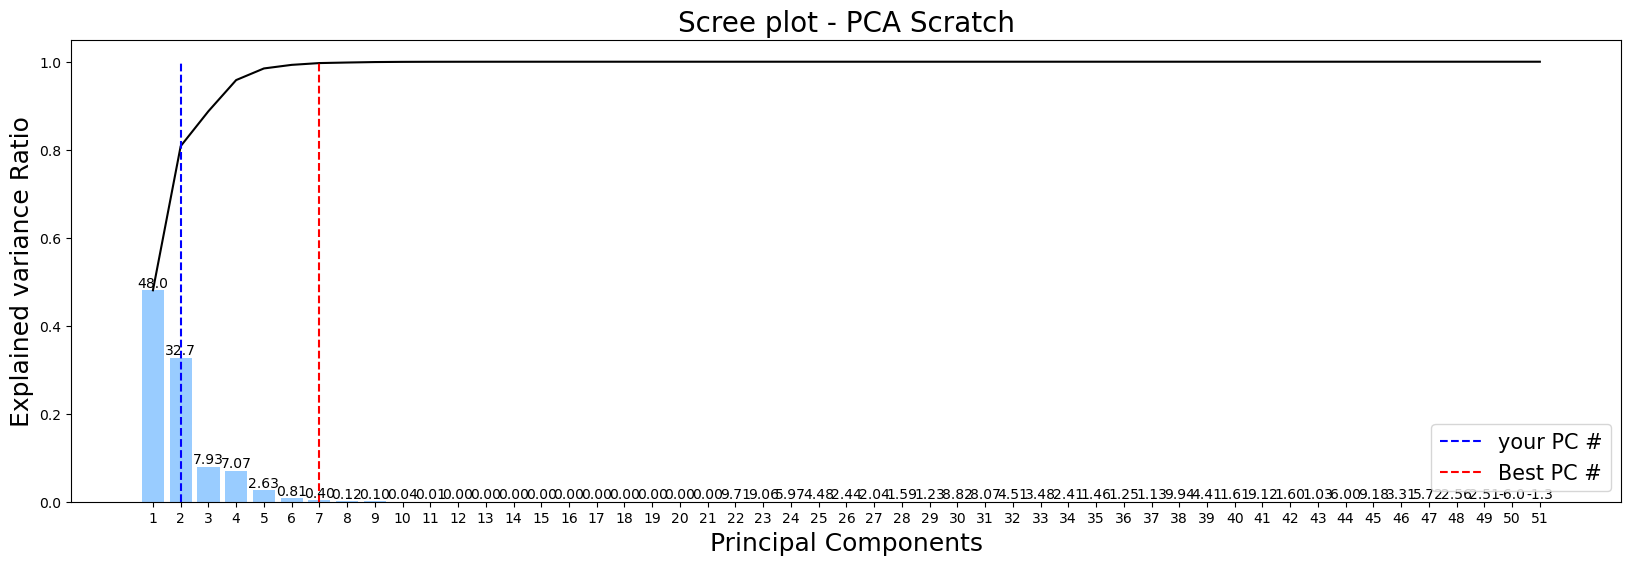

In [487]:
X_train_pca_2 = pca(X_train, 2, 0.01 , scree = True)

In [491]:
X_test_pca_2 = pca(X_test, 2, 0.01, scree = False)

### With PCA (PC = 7)

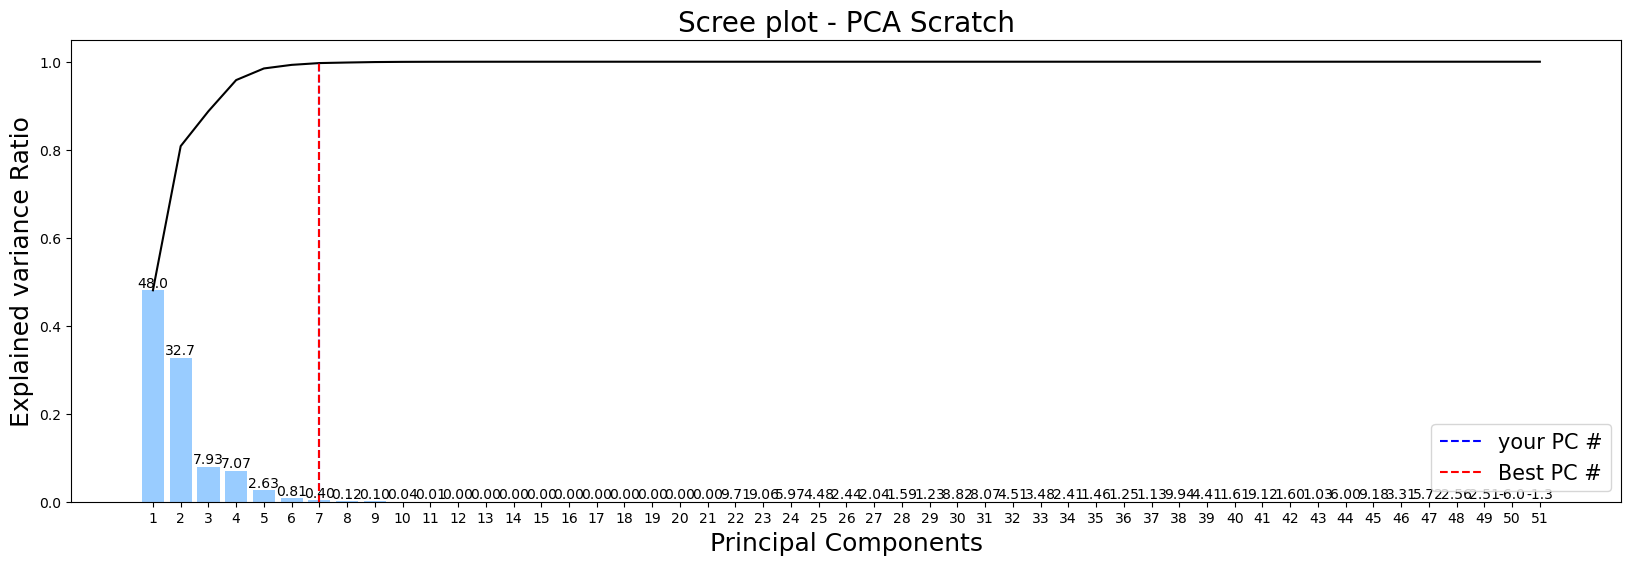

In [489]:
X_train_pca_7 = pca(X_train, 7,0.01)

In [490]:
X_test_pca_7 = pca(X_test, 7,0.01, scree = False)

## 3.4. Scratch vs library (scree plot)

In [492]:
# Normalize the Data
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [493]:
pca = PCA()
X_train_pca_lib = pca.fit_transform(X_train_norm)
explained_variance_ratio = pca.explained_variance_ratio_

In [495]:
def lib_scree_plot(pca_instance, threshold = 0.01):
    num_components = len(pca_instance.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_instance.explained_variance_ratio_ 
    
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot()
    cumvals = np.cumsum(vals)
    
    max_val = 0

    for value in cumulated:
        if (value - max_val) >= threshold:
            max_val = value
    
    ax.vlines(pca.n_components_, 0, max(cumulated), color = "blue", linestyles="--",label="your PC #")
    ax.vlines(np.where(cumulated==max_val)[0]+1, 0, max(cumulated), color = "red", linestyles="--", label = "Best PC #")
    
    ax.bar(ind, vals, color = '#ff6f15') # Bar plot
    ax.plot(ind, cumvals, color = 'black') # Line plot 


    for i in range(num_components): #라벨링(바 위에 텍스트(annotation) 쓰기)
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va = "bottom", ha = "center", fontsize = 13)
    
    ax.set_xticks(np.arange(1,num_components+1))
    ax.set_xlabel("Principal Components", fontsize = 18)
    ax.set_ylabel("Explained variance Ratio", fontsize = 18)

    plt.legend(loc = "best", fontsize = 15)
    plt.title('Scree plot - sklearn.decomposition PCA', fontsize = 20)

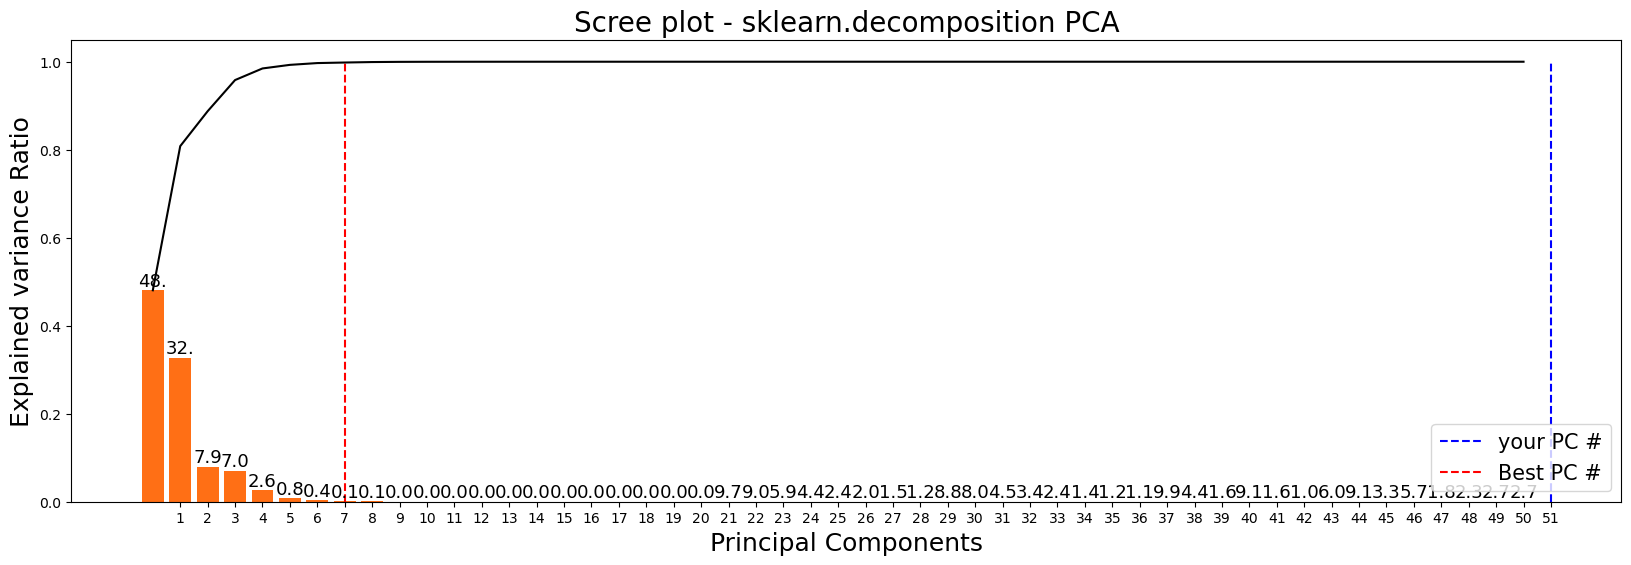

In [496]:
lib_scree_plot(pca)

## 3.5. (K-NN classification) Determination of the optimal K-values of K-NN algorithm.

In [497]:
def optimal_k(X_train, y_train, X_test, y_test, max_k = 30):
    errors = []
    for i in range(1, max_k+1):
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        errors.append(np.mean(pred_i != y_test))

    opt_k = errors.index(min(errors)) + 1
    
    plt.plot(range(1, max_k+1), errors, marker='o')
    plt.vlines(opt_k, 0, max(errors), color = "red", linestyles="--")
    plt.title('Mean error depending on K-Value')
    plt.xlabel('k-value')
    plt.xticks(np.arange(1, max_k+1))
    plt.ylabel('mean error')
    plt.figure(figsize=(20,6))
    plt.show()
    
    return opt_k

## 3.6. Plot the Performance

### Plot confusion matrix

In [498]:
# plot the performance of the model
def confusion_plot(conf_matrix, clf, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title(f'Confusion Matrix-{title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Plot accuracy plot according to number of neighborhood (K)

In [519]:
# Return the list of the accuracy according to K-values for K-NN algorithm (for scratch PCA)
def acc_k_val(X_train, y_train, X_test, y_test, max_k = 30):
    accs = []
    for i in range(1, max_k+1):
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        acc = accuracy_score(y_test, pred_i)
        accs.append(acc)

    return accs

In [520]:
# Return the list of the accuracy according to K-values for K-NN algorithm (for library PCA)
def acc_k_val_lib(X_train, y_train, X_test, y_test, n_comp ,max_k = 30):
    accs = []
    for i in range(1, max_k+1):
        pca_lib = PCA(n_components = n_comp)
        X_train_pca_lib = pca_lib.fit_transform(X_train)
        X_test_pca_lib = pca_lib.fit_transform(X_test)
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train_pca_lib, y_train)
        pred_i = knn.predict(X_test_pca_lib)
        acc = accuracy_score(y_test, pred_i)
        accs.append(acc)

    return accs

### Plot Accuracy plot according to the number of components of PCA

In [527]:
# Return the list of accuracies according to the number of components
def acc_component_num(X_train, y_train, X_test, y_test, k_num):
    accs = []
    max_num = X_train.shape[1]
    for i in range(0, max_num+1):
        if i == 0:
            reduced_train = X_train
            reduced_test = X_test
        else:
            reduced_train = pca(X_train, i, scree = False)
            reduced_test = pca(X_test, i, scree=False)
        
        knn = KNeighborsClassifier(n_neighbors = k_num)
        knn.fit(reduced_train, y_train)
        pred_i = knn.predict(reduced_test)
        acc = accuracy_score(y_test, pred_i)
        accs.append(acc)

    return accs

# 4. K-NN Classifier


## 4.1. Classification without PCA

* pca를 쓰지 않기 때문에 standarzation을 따로 시켜줘야 한다.

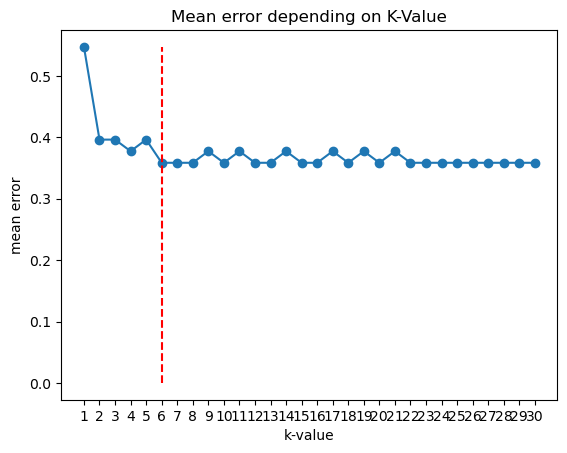

<Figure size 2000x600 with 0 Axes>

In [501]:
# Find optimal k value for K-NN classifier
opt_k = optimal_k(X_train_stand, y_train, X_test_stand, y_test, max_k = 30)

In [502]:
# k-NN 분류기를 생성
classifier = KNeighborsClassifier(n_neighbors=opt_k)
# 분류기 학습
classifier.fit(X_train_stand, y_train)

KNeighborsClassifier(n_neighbors=6)

In [503]:
# 예측
y_pred_stand= classifier.predict(X_test_stand)

### 4.1.1. Result of classification without PCA

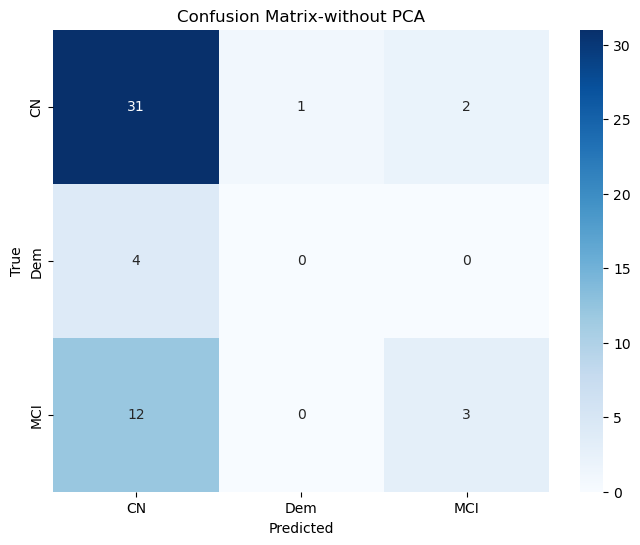

In [448]:
no_pca_conf_matrix= confusion_matrix(y_test, y_pred_stand)
confusion_plot(no_pca_conf_matrix, classifier, "without PCA")

In [504]:
no_pca_performance = classification_report(y_test, y_pred_stand)
print(no_pca_performance)

              precision    recall  f1-score   support

          CN       0.66      0.91      0.77        34
         Dem       0.00      0.00      0.00         4
         MCI       0.60      0.20      0.30        15

    accuracy                           0.64        53
   macro avg       0.42      0.37      0.36        53
weighted avg       0.59      0.64      0.58        53



## 4.2. Classification with PCA

### 4.2.1. When PC = 2

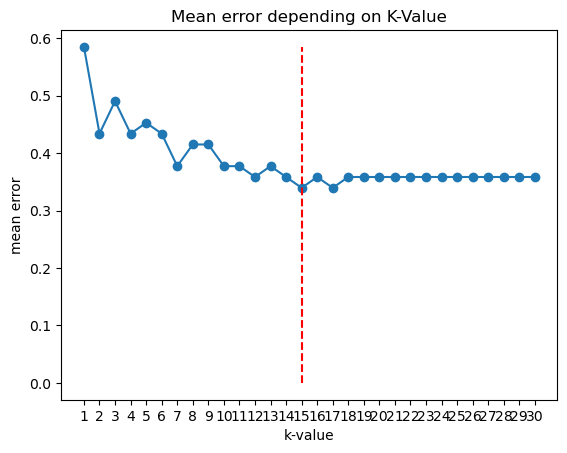

<Figure size 2000x600 with 0 Axes>

In [505]:
# Find optimal k value for K-NN classifier
opt_k2 = optimal_k(X_train_pca_2, y_train, X_test_pca_2, y_test, max_k = 30)

In [506]:
# k-NN 분류기를 생성
classifier = KNeighborsClassifier(n_neighbors=opt_k2)
# 분류기 학습
classifier.fit(X_train_pca_2, y_train)

KNeighborsClassifier(n_neighbors=15)

In [507]:
# 예측
y_pred_pca2= classifier.predict(X_test_pca_2)

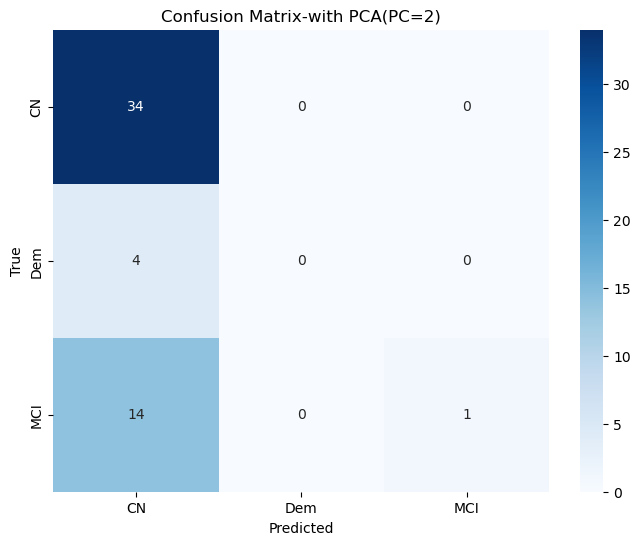

In [508]:
pca2_conf_matrix= confusion_matrix(y_test, y_pred_pca2)
confusion_plot(pca2_conf_matrix, classifier, "with PCA(PC=2)")

In [509]:
pca2_performance = classification_report(y_test, y_pred_pca2)
print(pca2_performance)

              precision    recall  f1-score   support

          CN       0.65      1.00      0.79        34
         Dem       0.00      0.00      0.00         4
         MCI       1.00      0.07      0.12        15

    accuracy                           0.66        53
   macro avg       0.55      0.36      0.31        53
weighted avg       0.70      0.66      0.54        53



/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.2.2. When PC = 6 (Best # of PC)

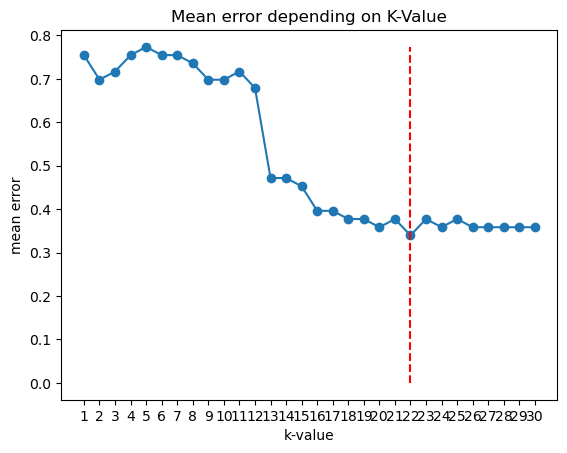

<Figure size 2000x600 with 0 Axes>

In [510]:
# Find optimal k value for K-NN classifier
opt_k7 = optimal_k(X_train_pca_7, y_train, X_test_pca_7, y_test, max_k = 30)

In [511]:
# k-NN 분류기를 생성
classifier = KNeighborsClassifier(n_neighbors=opt_k7)
# 분류기 학습
classifier.fit(X_train_pca_7, y_train)

KNeighborsClassifier(n_neighbors=22)

In [513]:
# 예측
y_pred_pca7= classifier.predict(X_test_pca_7)

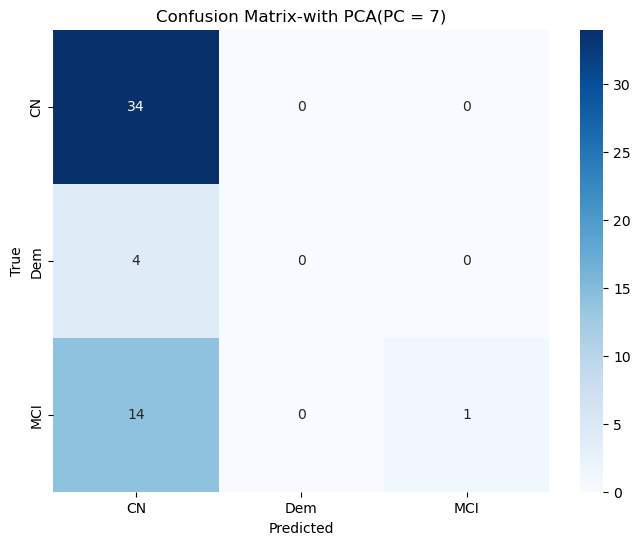

In [514]:
pca7_conf_matrix= confusion_matrix(y_test, y_pred_pca7)
confusion_plot(pca7_conf_matrix, classifier, "with PCA(PC = 7)")

In [515]:
pca7_performance = classification_report(y_test, y_pred_pca7)
print(pca7_performance)

              precision    recall  f1-score   support

          CN       0.65      1.00      0.79        34
         Dem       0.00      0.00      0.00         4
         MCI       1.00      0.07      0.12        15

    accuracy                           0.66        53
   macro avg       0.55      0.36      0.31        53
weighted avg       0.70      0.66      0.54        53



/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoobin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* Same Performance

## 4.3. Accuracy of K-NN classification according to K values

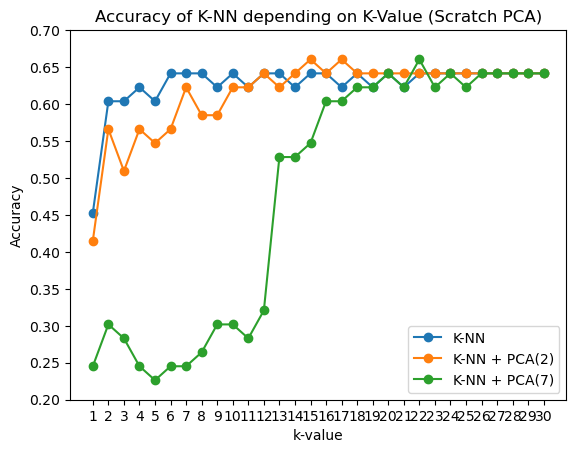

<Figure size 2000x600 with 0 Axes>

In [542]:
k = 30

acc_no = acc_k_val(X_train_stand, y_train, X_test_stand, y_test, k)
acc_2 = acc_k_val(X_train_pca_2, y_train, X_test_pca_2, y_test, k)
acc_7 = acc_k_val(X_train_pca_7, y_train, X_test_pca_7, y_test, k)

plt.plot(range(1, k+1), acc_no, marker='o', label = "K-NN")
plt.plot(range(1, k+1), acc_2, marker='o', label = "K-NN + PCA(2)")
plt.plot(range(1, k+1), acc_7, marker='o', label = "K-NN + PCA(7)")
plt.title('Accuracy of K-NN depending on K-Value (Scratch PCA)')
plt.xlabel('k-value')
plt.xticks(np.arange(1, k+1))
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.20, 0.75, 0.05))
plt.legend(loc="lower right")
plt.figure(figsize=(20,6))


plt.show()

In [524]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

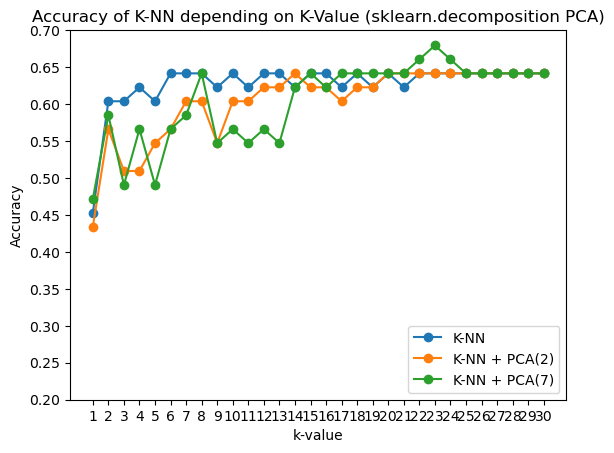

<Figure size 2000x600 with 0 Axes>

In [554]:
k = 30

acc_2_lib = acc_k_val_lib(X_train_norm, y_train, X_test_norm, y_test, 2, k)
acc_7_lib = acc_k_val_lib(X_train_norm, y_train, X_test_norm, y_test, 7, k)

plt.plot(range(1, k+1), acc_no, marker='o', label = "K-NN")
plt.plot(range(1, k+1), acc_2_lib, marker='o', label = "K-NN + PCA(2)")
plt.plot(range(1, k+1), acc_7_lib, marker='o', label = "K-NN + PCA(7)")
plt.title('Accuracy of K-NN depending on K-Value (sklearn.decomposition PCA)')
plt.xlabel('k-value')
plt.xticks(np.arange(1, k+1))
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.20, 0.75, 0.05))
plt.legend(loc="lower right")
plt.figure(figsize=(20,6))


plt.show()

## 4.4. Accuracy according to the number of Principal component (k = 22)

In [528]:
X_train.shape[1]

51

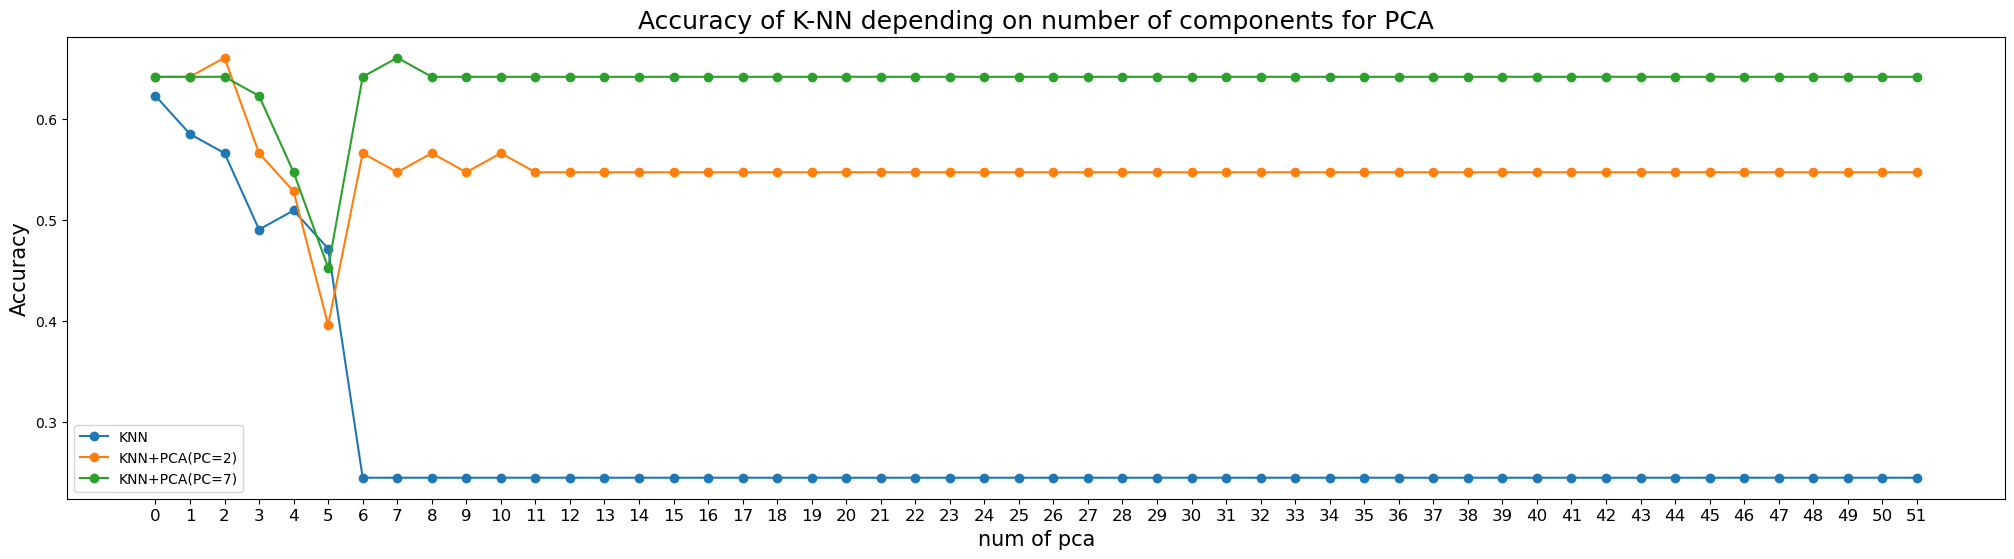

In [535]:
acc_to_pca_6 = acc_component_num(X_train, y_train, X_test, y_test, 6)
acc_to_pca_15 = acc_component_num(X_train, y_train, X_test, y_test, 15)
acc_to_pca_22 = acc_component_num(X_train, y_train, X_test, y_test, 22)

plt.figure(figsize=(25,6))

plt.plot(range(0, X_train.shape[1]+1), acc_to_pca_6, marker='o', label = "KNN")
plt.plot(range(0, X_train.shape[1]+1), acc_to_pca_15, marker='o', label = "KNN+PCA(PC=2)")
plt.plot(range(0, X_train.shape[1]+1), acc_to_pca_22, marker='o', label = "KNN+PCA(PC=7)")
plt.title(f'Accuracy of K-NN depending on number of components for PCA', fontsize=18)
plt.xlabel('num of pca', fontsize = 15)
plt.xticks(np.arange(0, X_train.shape[1]+1), fontsize = 12)
plt.ylabel('Accuracy', fontsize = 15)

plt.legend(loc = "best")

plt.show()

# Reference
1. [PCA scratch](https://www.askpython.com/python/examples/principal-component-analysis)
2. [Data Normalization](https://stackoverflow.com/questions/21030391/how-to-normalize-a-numpy-array-to-a-unit-vector)
3. [Scree plot - concept](https://sanchitamangale12.medium.com/scree-plot-733ed72c8608)
4. [Scree plot - implementation](https://velog.io/@yuns_u/PCA-Scree-Plot)
5. [K-NN Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
6. [Debugging and visualization](https://chat.openai.com)